In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split

from keras.layers.embeddings import Embedding
from keras.layers import GlobalAveragePooling1D

ModuleNotFoundError: No module named 'numpy'

In [2]:
#Locate and list all xlms files so they can be opened all together

import os

xlms_files = []
for root, dirs, files in os.walk("."):  
    for filename in files:
        if filename[-4:]=='xlsm':  #Add to the list if the element's last four spaces form the word "xlsm"
            xlms_files += [filename]
        
xlms_files

['Rolls Royce Derby EOS Rotatives.xlsm',
 'Rolls Royce Jubilee House.xlsm',
 'Tag_50111119_Gillingham_Operations_Centre.xlsm',
 '2018-96-05 Bracknell Waterside House.xlsm',
 'Tag_50450069_Andover_Keens_House.xlsm',
 'Vodafone Atlas Park.xlsm',
 'Rolls Royce Heathrow.xlsm',
 'Rolls Royce Barnoldswick.xlsm',
 'Tag_50450189_Manchester_Brotherton_House.xlsm']

In [3]:
#concatenate all files into a huge dataset

inputs = []

for file in xlms_files:
    xl = pd.ExcelFile(file)
    if "Input" in xl.sheet_names:
        df = xl.parse('Tagging') #Go to "Tagging" tab
        df.columns = df.iloc[1] #Re-define index
        df = df.reindex(df.index.drop(0)) #Drop the other two columns
        df = df.reindex(df.index.drop(1))
        df = df.dropna(thresh=5) #Discard all the rows with at least 5 NaN elements
        inputs += [df] 

inputs = pd.concat(inputs) #Concatenate them one below the next one
inputs = inputs.dropna(subset=["Service"]) #Drop row if service value is equals zero
inputs = inputs.reset_index() #Restart the index from zero to its length
inputs = inputs.drop(columns=["index"]) #Drop old index
inputs = inputs.fillna(0)


In [4]:
inputs

1           Outstation     OS type                        Label    Type  \
0      Shared Services      IQ4E64        Compressor House Fans    Bool   
1      Shared Services      IQ4E64      Compressed Air Pressure  Number   
2      Shared Services      IQ4E64         Compressions Air Met  Number   
3      Shared Services      IQ4E64         Comp Air Hi Press SP  Number   
4      Shared Services      IQ4E64         Comp Air Lo Press SP  Number   
5      Shared Services      IQ4E64        Compressor Ext Fan SP  Number   
6      Shared Services      IQ4E64        Compressor House Temp  Number   
7      Shared Services      IQ4E64           Compressor 1 Fault    Bool   
8      Shared Services      IQ4E64           Compressor 2 Fault    Bool   
9      Shared Services      IQ4E64           Compressor 3 Fault    Bool   
10     Shared Services      IQ4E64           Compressor 4 Fault    Bool   
11     Shared Services      IQ4E64           Compressor 5 Fault    Bool   
12     Shared Services      IQ4E64    Compressor Ext Fans Fault    Bool   
13     Shared Services      IQ4E64         Condenser Unit Fault    Bool   
14     Shared Services      IQ4E64        Cryo Compressor Fault    Bool   
15     Shared Services      IQ4E64              Cryo Unit Fault    Bool   
16     Shared Services      IQ4E64         Comp Air Hi-Pressure    Bool   
17     Shared Services      IQ4E64         Comp Air Lo-Pressure    Bool   
18     Shared Services      IQ4E64           Compress Air Pulse    Bool   
19     Shared Services      IQ4E64         Compressor 1 Running    Bool   
20     Shared Services      IQ4E64         Compressor 2 Running    Bool   
21     Shared Services      IQ4E64         Compressor 3 Running    Bool   
22     Shared Services      IQ4E64         Compressor 4 Running    Bool   
23     Shared Services      IQ4E64         Compressor 5 Running    Bool   
24     Shared Services      IQ4E64  Compressor Ext Fans Running    Bool   
25     Shared Services      IQ4E64        Condenser Hi PH level    Bool   
26     Shared Services      IQ4E64          Potable CWS Booster    Bool   
27     Shared Services      IQ4E64            Potable Low Water    Bool   
28     Shared Services      IQ4E64           Potable Tank Level  Number   
29     Shared Services      IQ4E64          Potable Booster Flt    Bool   
...                ...         ...                          ...     ...   
10937   COMPUTER CHILL       IQ131                  PUMP A TRIP    Bool   
10938   COMPUTER CHILL       IQ131                  PUMP B TRIP    Bool   
10939   COMPUTER CHILL       IQ131                   PUMP B RUN    Bool   
10940         Chillers  IQ3xcite96          Chiller A Flow Temp  Number   
10941         Chillers  IQ3xcite96        Chiller A Return Temp  Number   
10942         Chillers  IQ3xcite96          Chiller B Flow Temp  Number   
10943         Chillers  IQ3xcite96        Chiller B Return Temp  Number   
10944     BOILER PLANT       IQ233                     Boiler 1    Bool   
10945     BOILER PLANT       IQ233            BLR 1 3PORT VALVE    Bool   
10946     BOILER PLANT       IQ233            BOILER 1 HIGHTEMP    Bool   
10947     BOILER PLANT       IQ233             BOILER 1 LOCKOUT    Bool   
10948     BOILER PLANT       IQ233                     Boiler 2    Bool   
10949     BOILER PLANT       IQ233            BLR 2 3PORT VALVE    Bool   
10950     BOILER PLANT       IQ233             BOILER 2 LOCKOUT    Bool   
10951     BOILER PLANT       IQ233            BOILER 2 HIGHTEMP    Bool   
10952     BOILER PLANT       IQ233                     Boiler 3    Bool   
10953     BOILER PLANT       IQ233            BLR 3 3PORT VALVE    Bool   
10954     BOILER PLANT       IQ233             BOILER 3 LOCKOUT    Bool   
10955     BOILER PLANT       IQ233            BOILER 3 HIGHTEMP    Bool   
10956            GAMES       IQ233         GAMES SUPPLY/EXTRACT    Bool   
10957            GAMES       IQ233            Meeting Room  Ahu    Bool   
10958     OFFICE BLOCK   

In [5]:
def unique_list(words_list):
    unique_words = []
    for i in words_list:
        if i not in unique_words:
            unique_words += [i]
    
    return unique_words

In [6]:
labels = inputs['Label'].values

for i in range(0,len(labels)-1):
    
    if type(labels[i])==int or labels[i]== '': #Delete values in "Label" that are integers, because they don't make any sense
        
        labels=np.delete(labels,i)
        inputs=inputs.drop(inputs.index[i])
        continue

## Defining the algorithm outputs y

In [7]:
outputs = inputs['Service'].values
        
outputs = outputs.tolist()

unique_list_outputs = unique_list(outputs)
unique_numbers_outputs = np.arange(0,len(unique_list_outputs)).tolist()
unique_outputs = dict(zip(unique_list_outputs, unique_numbers_outputs))

y = [unique_outputs[label] for label in outputs]

In [8]:
unique_outputs

{'Cooling': 0,
 'Globals': 1,
 'Heating': 2,
 'Ignore point': 3,
 'Lighting': 4,
 'Metering': 5,
 'Monitoring': 6,
 'Terminals': 7,
 'Ventilation': 8}

In [9]:
# USE THIS NEXT TIME FOR HOT ENCODING, CABESA 
#encoded = [keras.preprocessing.text.one_hot(d, 10, split='!') for d in outputs]

In [10]:
encoded = np.array(y)

In [11]:
onehot_encoder = OneHotEncoder(sparse=False)
encoded = encoded.reshape(len(encoded), 1)
y_onehot = onehot_encoder.fit_transform(encoded)

In [12]:
y_onehot.shape

(10966, 9)

## Defining the algorithm inputs X

In [13]:
#HERE IS WHERE I DECIDE THE INPUTS
X = inputs[["Label"]]
X = [" ".join(X.values.tolist()[i]) for i in range(0,len(X))]

X = [X[i].split() for i in range(0,len(X))]

labels_flattened = []

for i in range(0,len(X)):
    labels_flattened += X[i]
    
unique_lis = unique_list(labels_flattened)
unique_numbers = np.arange(1,len(unique_lis)+1)
unique = dict(zip(unique_lis, unique_numbers))

for i in range(0,len(X)):   
    X[i] = [unique[label] for label in X[i]]

In [14]:
len(X) == len(y)

True

In [15]:
#We calculate the maximum length of the list
max_len = 0

for i in range(0,len(X)):
    if len(X[i])>max_len:
        max_len = len(X[i])
        
print("The maximum length of the lists is", max_len)

The maximum length of the lists is 10


In [16]:
X_padded = np.reshape(np.pad(np.asarray(X[0]),(0,max_len-len(X[0])), 'constant',constant_values=(0,0)),(1,-1))

In [17]:
X_padded

array([[1, 2, 3, 0, 0, 0, 0, 0, 0, 0]])

In [18]:
for i in range(1,len(X)):
    add_X = np.reshape(np.pad(np.asarray(X[i]),(0,max_len-len(X[i])), 'constant',constant_values=(0,0)),(1,-1))
    X_padded = np.concatenate([X_padded,add_X],axis=0)

In [19]:
X_padded.shape

(10966, 10)

In [20]:
X_padded[9]

array([ 1, 20, 18,  0,  0,  0,  0,  0,  0,  0])

In [21]:
x_val = X_padded[6000:]
partial_x_train = X_padded[:6000]

y_val = y_onehot[6000:]
partial_y_train = y_onehot[:6000]

In [22]:
partial_x_train.shape

(6000, 10)

## Designing embeeder model

In [27]:
"""
#input shape is the vocabulary count used for the input tags
def baseline_model():   
    vocab_size = 1389
    #vocab_size = 10
    embedding_size = int(len(unique_lis)/333)
    
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, embedding_size))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dense(embedding_size, activation=tf.nn.relu))
    model.add(keras.layers.Dense(9, activation=tf.nn.softmax))
    model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model
"""
#model.summary()
from keras.layers import InputLayer

vocab_size = 1489 
embedding_size = int(len(unique_lis)/333)

def baseline():    
    # create model
    model = Sequential()
    #model.add(keras.layers.Embedding(vocab_size, embedding_size),input_length=10)
    model.add(Embedding(vocab_size, embedding_size, input_length=10))
    model.add(GlobalAveragePooling1D())
    #model.add(Dense(8, input_dim=4, activation='relu'))
    model.add(Dense(9, activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [28]:
estimator = KerasClassifier(build_fn=baseline, epochs=100, batch_size=20, verbose=1)

In [29]:
estimator.fit(partial_x_train, partial_y_train)

Epoch 1/100
6000/6000 [==============================] - 1s 95us/step - loss: 2.0159 - acc: 0.5103
Epoch 2/100
6000/6000 [==============================] - 0s 69us/step - loss: 1.5713 - acc: 0.5193
Epoch 3/100
6000/6000 [==============================] - 0s 65us/step - loss: 1.3522 - acc: 0.5193
Epoch 4/100
6000/6000 [==============================] - 0s 66us/step - loss: 1.2763 - acc: 0.5193
Epoch 5/100
6000/6000 [==============================] - 0s 63us/step - loss: 1.2282 - acc: 0.5193
Epoch 6/100
6000/6000 [==============================] - 0s 66us/step - loss: 1.1788 - acc: 0.5215
Epoch 7/100
6000/6000 [==============================] - 0s 66us/step - loss: 1.1200 - acc: 0.5363
Epoch 8/100
6000/6000 [==============================] - 0s 63us/step - loss: 1.0458 - acc: 0.5763
Epoch 9/100
6000/6000 [==============================] - 0s 75us/step - loss: 0.9586 - acc: 0.6317
Epoch 10/100
6000/6000 [==============================] - 0s 76us/step - loss: 0.8732 - acc: 0.7290
Epoch 11/

6000/6000 [==============================] - 0s 53us/step - loss: 0.1160 - acc: 0.9693
Epoch 84/100
6000/6000 [==============================] - 0s 55us/step - loss: 0.1146 - acc: 0.9700
Epoch 85/100
6000/6000 [==============================] - 0s 50us/step - loss: 0.1133 - acc: 0.9703
Epoch 86/100
6000/6000 [==============================] - 0s 53us/step - loss: 0.1120 - acc: 0.9708
Epoch 87/100
6000/6000 [==============================] - 0s 53us/step - loss: 0.1108 - acc: 0.9712
Epoch 88/100
6000/6000 [==============================] - 0s 67us/step - loss: 0.1096 - acc: 0.9713
Epoch 89/100
6000/6000 [==============================] - 0s 63us/step - loss: 0.1087 - acc: 0.9710
Epoch 90/100
6000/6000 [==============================] - 0s 63us/step - loss: 0.1073 - acc: 0.9718
Epoch 91/100
6000/6000 [==============================] - 0s 55us/step - loss: 0.1062 - acc: 0.9722
Epoch 92/100
6000/6000 [==============================] - 0s 54us/step - loss: 0.1054 - acc: 0.9727
Epoch 93/100


In [30]:
predicted_labels = estimator.predict(x_val)
predicted_labels

  20/4966 [..............................] - ETA: 6s

InvalidArgumentError: indices[16,1] = 1489 is not in [0, 1489)
	 [[Node: embedding_2/embedding_lookup = GatherV2[Taxis=DT_INT32, Tindices=DT_INT32, Tparams=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding_2/embeddings/read, embedding_2/Cast, embedding_2/embedding_lookup/axis)]]

In [ ]:
tags = np.reshape(inputs["Label"].values[6000:],(-1,1))
true_labels = encoded[6000:]
predicted_labels = np.reshape(predicted_labels,(-1,1))
comparison = np.equal(true_labels,predicted_labels)

In [ ]:
tags.shape, true_labels.shape, predicted_labels.shape, comparison.shape

In [ ]:
true_count = list(comparison).count(True)
false_count = list(comparison).count(False)

print("The % of correctly predicted elements is: ", (len(comparison)-false_count)/len(comparison)*100,"%")

In [124]:
df_result = pd.DataFrame(np.concatenate((tags,true_labels,predicted_labels,comparison),axis=1),columns=["Tag","Service","Predicted Service","Success"])

In [125]:
df_result.to_csv("first_result.csv")

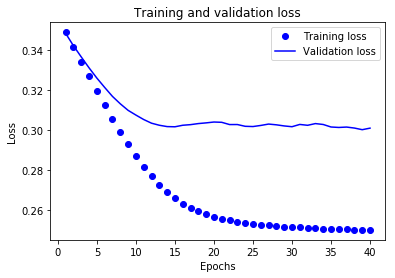

In [401]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

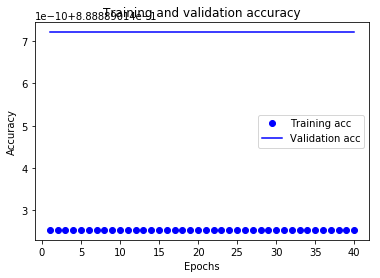

In [402]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [403]:
pos = 78

prediction = model.predict(x_val[pos])

prediction.shape

(1388, 4)

In [404]:
x_val[pos]

array([0, 0, 0, ..., 0, 0, 0])

In [405]:
prediction

array([[0.37490517, 0.0213245 , 0.3699201 , 0.11202104],
       [0.37490517, 0.0213245 , 0.3699201 , 0.11202104],
       [0.37490517, 0.0213245 , 0.3699201 , 0.11202104],
       ...,
       [0.37490517, 0.0213245 , 0.3699201 , 0.11202104],
       [0.37490517, 0.0213245 , 0.3699201 , 0.11202104],
       [0.37490517, 0.0213245 , 0.3699201 , 0.11202104]], dtype=float32)

In [406]:
x_val.shape

(6000, 1388)